# Predict engagement and emotions on video with EmotiEffCppLib

Include some system headers:

In [1]:
#include <iostream>
#include <string>
#include <vector>
#include <fstream>

Specify local path to the directory with EmotiEffLib:

In [2]:
const std::string emotiEffLibRootDir = "/home/jovyan";

Specify some pragmas related to the emotiEffLibRootDir directory:

In [3]:
// NOTE: It is important that all paths in pragma should be specified as a string constant.
// Please, copy value of emotiEffLibRootDir to the next pragmas:

// Path to EmotiEffCpp lib dependencies
#pragma cling add_include_path("/home/jovyan/emotieffcpplib/include")
#pragma cling add_include_path("/home/jovyan/emotieffcpplib/3rdparty/opencv-mtcnn/lib/include")
#pragma cling add_include_path("/home/jovyan/emotieffcpplib/3rdparty/xtensor/include")

// Path to includes for drawing images
#pragma cling add_include_path("./json/single_include")
#pragma cling add_include_path("/home/jovyan/emotieffcpplib/3rdparty/xtl/include")

// Link libraries
#pragma cling add_library_path("/home/jovyan/build/lib")
#pragma cling load("emotiefflib")
#pragma cling load("mtcnn")

Specify here paths to the directories with runtimes:

In [4]:
// Path to ONNXRuntime
#pragma cling add_include_path("/home/jovyan/onnxruntime/include")
// Path to Libtorch
#pragma cling add_include_path("/home/jovyan/libtorch/include")

Add linking with OpenCV libraries:

In [5]:
// Path to OpenCV
#pragma cling add_include_path("/usr/include/opencv4")

// OpenCV libs
#pragma cling load("libopencv_shape")
#pragma cling load("libopencv_stitching")
#pragma cling load("libopencv_objdetect")
#pragma cling load("libopencv_superres")
#pragma cling load("libopencv_videostab")
#pragma cling load("libopencv_calib3d")
#pragma cling load("libopencv_features2d")
#pragma cling load("libopencv_highgui")
#pragma cling load("libopencv_videoio")
#pragma cling load("libopencv_imgcodecs")
#pragma cling load("libopencv_video")
#pragma cling load("libopencv_photo")
#pragma cling load("libopencv_ml")
#pragma cling load("libopencv_imgproc")
#pragma cling load("libopencv_dnn")
#pragma cling load("libopencv_viz")

Include necessary headers:

In [6]:
#include <emotiefflib/facial_analysis.h>
#include <mtcnn/detector.h>

#include <xtensor/xarray.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xmath.hpp>
#include <xtensor/xsort.hpp>

#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"

Define some common variables:

In [7]:
auto videoPath = emotiEffLibRootDir + "/tests/data/video_samples/engagement/engaged/1_video1.mp4";
std::string backend;
std::string modelName;
std::unique_ptr<EmotiEffLib::EmotiEffLibRecognizer> fer;
std::string ext;

## Helper functions

Functions to draw image:

In [8]:
namespace nl = nlohmann;

namespace im
{
    struct image
    {
        inline image(const std::string& filename)
        {
            std::ifstream fin(filename, std::ios::binary);
            m_buffer << fin.rdbuf();
        }

        image(const cv::Mat& image)
        {
            // Encode the image into memory
            std::vector<uchar> buffer;
            cv::imencode(".jpg", image, buffer);
            
            m_buffer.write(reinterpret_cast<const char*>(buffer.data()), buffer.size());
        }

        std::stringstream m_buffer;
    };

    nl::json mime_bundle_repr(const image& i)
    {
        auto bundle = nl::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer.str());
        return bundle;
    }
}

Helper function to resize cv::Mat:

In [9]:
cv::Mat resizeWithAspectRatio(const cv::Mat& img, int target_width = 0, int target_height = 0) {
    if (img.empty()) {
        std::cerr << "Error: Image is empty!" << std::endl;
        return cv::Mat();
    }

    int original_width = img.cols;
    int original_height = img.rows;
    double aspect_ratio = (double)original_width / original_height;

    int new_width = target_width;
    int new_height = target_height;

    if (target_width > 0 && target_height == 0) {
        new_height = static_cast<int>(target_width / aspect_ratio);
    } else if (target_height > 0 && target_width == 0) {
        new_width = static_cast<int>(target_height * aspect_ratio);
    } else if (target_width == 0 && target_height == 0) {
        return img.clone();  // No resizing needed
    }

    cv::Mat resized_img;
    cv::resize(img, resized_img, cv::Size(new_width, new_height), 0, 0, cv::INTER_LINEAR);
    return resized_img;
}

To improve performance, we downscale the input image before faces recognition:

In [10]:
cv::Mat downscaleImageToWidth(const cv::Mat& inputImage, int targetWidth) {
    // Get the original dimensions
    int originalWidth = inputImage.cols;
    int originalHeight = inputImage.rows;

    if (originalWidth < targetWidth)
        return inputImage;

    // Calculate the scaling factor
    double scaleFactor = static_cast<double>(targetWidth) / originalWidth;

    // Calculate the new height while maintaining the aspect ratio
    int targetHeight = static_cast<int>(originalHeight * scaleFactor);

    // Resize the image
    cv::Mat outputImage;
    cv::resize(inputImage, outputImage, cv::Size(targetWidth, targetHeight));

    return outputImage;
}

Function for faces recognition:

In [11]:
std::vector<cv::Mat> recognizeFaces(const cv::Mat& frame, int downscaleWidth = 500) {
    auto dirWithModels = emotiEffLibRootDir + "/emotieffcpplib/3rdparty/opencv-mtcnn/data/models";
    ProposalNetwork::Config pConfig;
    pConfig.protoText = dirWithModels + "/det1.prototxt";
    pConfig.caffeModel = dirWithModels + "/det1.caffemodel";
    pConfig.threshold = 0.6f;
    RefineNetwork::Config rConfig;
    rConfig.protoText = dirWithModels + "/det2.prototxt";
    rConfig.caffeModel = dirWithModels + "/det2.caffemodel";
    rConfig.threshold = 0.7f;
    OutputNetwork::Config oConfig;
    oConfig.protoText = dirWithModels + "/det3.prototxt";
    oConfig.caffeModel = dirWithModels + "/det3.caffemodel";
    oConfig.threshold = 0.7f;
    MTCNNDetector detector(pConfig, rConfig, oConfig);
    auto scaledFrame = downscaleImageToWidth(frame, downscaleWidth);
    double downcastRatioW = static_cast<double>(frame.cols) / scaledFrame.cols;
    double downcastRatioH = static_cast<double>(frame.rows) / scaledFrame.rows;
    std::vector<Face> faces = detector.detect(scaledFrame, 20.f, 0.709f);
    std::vector<cv::Mat> cvFaces = {};
    cvFaces.reserve(faces.size());
    for (auto& face : faces) {
        face.bbox.x1 *= downcastRatioW;
        face.bbox.x2 *= downcastRatioW;
        face.bbox.y1 *= downcastRatioH;
        face.bbox.y2 *= downcastRatioH;
        cv::Rect roi(face.bbox.x1, face.bbox.y1, face.bbox.x2 - face.bbox.x1,
                     face.bbox.y2 - face.bbox.y1);
        cv::Mat f = frame(roi).clone();
        cvFaces.push_back(f);
    }
    return cvFaces;
}

## Emotions recognition ONNX

Define backend and model name:

In [12]:
backend = "onnx";
modelName = EmotiEffLib::getSupportedModels(backend)[0];
ext = ".onnx";

### Read video and recognize engagement:

For engagement recognition, we need to collect a sequence of video frames before predicting engagement class. To avoid extracting visual features for the same frames in different sliding windows, it is better to read the whole video before recognizing engagement or extract visual features for each frame before passing them to classifier.

Read the whole video:

In [13]:
cv::VideoCapture cap(videoPath);
if (!cap.isOpened()) {
    throw std::runtime_error("Cannot open video file!");
}

cv::Mat frame;
std::vector<cv::Mat> allFaces;
while (cap.read(frame)) {
    auto faces = recognizeFaces(frame);
    if (faces.size() == 0) {
        continue;
    }
    allFaces.insert(allFaces.end(), faces.begin(), faces.end());
}

cap.release();

Display 100th frame:

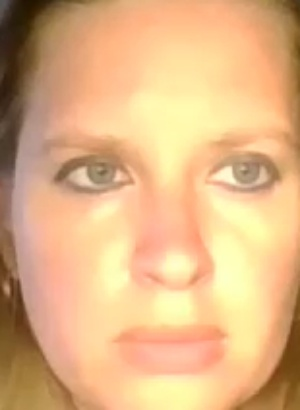

In [14]:
im::image img(resizeWithAspectRatio(allFaces[99], 300));
img

Recognize engagement using predict_engagement method:

In [15]:
std::string featureExtractorPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/features_extractor_" + modelName + ext;
std::string engagementClassifierPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/engagement_classifier_2560_128" + ext;
EmotiEffLib::EmotiEffLibConfig config;
config.backend = backend;
config.featureExtractorPath = featureExtractorPath;
config.engagementClassifierPath = engagementClassifierPath;
config.modelName = modelName;

fer = EmotiEffLib::EmotiEffLibRecognizer::createInstance(config);
auto res = fer->predictEngagement(allFaces);
auto score = xt::mean(res.scores, {0});
auto engagement_idx = xt::argmax(score)[0];

std::cout << fer->getEngagementClassById(engagement_idx) << " == Engaged" << std::endl;

Engaged == Engaged


### Recognize engagement and emotions on a sequence of frames by calling features extractor and classifier separately

In [16]:
std::string featureExtractorPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/features_extractor_" + modelName + ext;
std::string classifierPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/classifier_" + modelName + ext;
std::string engagementClassifierPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/engagement_classifier_2560_128" + ext;
EmotiEffLib::EmotiEffLibConfig config;
config.backend = backend;
config.featureExtractorPath = featureExtractorPath;
config.classifierPath = classifierPath;
config.engagementClassifierPath = engagementClassifierPath;
config.modelName = modelName;

fer = EmotiEffLib::EmotiEffLibRecognizer::createInstance(config);
auto features = fer->extractFeatures(allFaces);
auto res_emotions = fer->classifyEmotions(features, true);
auto score_emotions = xt::mean(res_emotions.scores, {0});
auto emotion_idx = xt::argmax(score_emotions)[0];
auto res_engagement = fer->classifyEngagement(features);
auto score_engagement = xt::mean(res_engagement.scores, {0});
auto engagement_idx = xt::argmax(score_engagement)[0];
std::cout << fer->getEmotionClassById(emotion_idx) << " == Anger" << std::endl;
std::cout << fer->getEngagementClassById(engagement_idx) << " == Engaged" << std::endl;

Anger == Anger
Engaged == Engaged


## Emotions recognition Torch

Define backend and model name:

In [17]:
backend = "torch";
modelName = EmotiEffLib::getSupportedModels(backend)[0];
ext = ".pt";

### Read video and recognize engagement:

For engagement recognition, we need to collect a sequence of video frames before predicting engagement class. To avoid extracting visual features for the same frames in different sliding windows, it is better to read the whole video before recognizing engagement or extract visual features for each frame before passing them to classifier.

Read the whole video:

In [18]:
cv::VideoCapture cap(videoPath);
if (!cap.isOpened()) {
    throw std::runtime_error("Cannot open video file!");
}

cv::Mat frame;
std::vector<cv::Mat> allFaces;
while (cap.read(frame)) {
    auto faces = recognizeFaces(frame);
    if (faces.size() == 0) {
        continue;
    }
    allFaces.insert(allFaces.end(), faces.begin(), faces.end());
}

cap.release();

Display 100th frame:

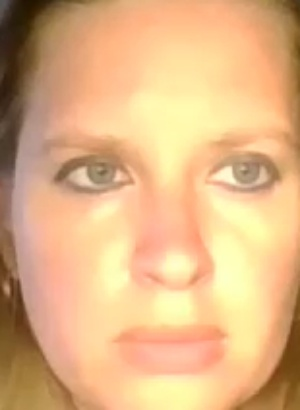

In [19]:
im::image img(resizeWithAspectRatio(allFaces[99], 300));
img

Recognize engagement using predict_engagement method:

In [20]:
std::string featureExtractorPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/features_extractor_" + modelName + ext;
std::string engagementClassifierPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/engagement_classifier_2560_128" + ext;
EmotiEffLib::EmotiEffLibConfig config;
config.backend = backend;
config.featureExtractorPath = featureExtractorPath;
config.engagementClassifierPath = engagementClassifierPath;
config.modelName = modelName;

fer = EmotiEffLib::EmotiEffLibRecognizer::createInstance(config);
auto res = fer->predictEngagement(allFaces);
auto score = xt::mean(res.scores, {0});
auto engagement_idx = xt::argmax(score)[0];

std::cout << fer->getEngagementClassById(engagement_idx) << " == Engaged" << std::endl;

### Recognize engagement and emotions on a sequence of frames by calling features extractor and classifier separately

In [21]:
std::string featureExtractorPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/features_extractor_" + modelName + ext;
std::string classifierPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/classifier_" + modelName + ext;
std::string engagementClassifierPath = emotiEffLibRootDir + "/models/emotieffcpplib_prepared_models/engagement_classifier_2560_128" + ext;
EmotiEffLib::EmotiEffLibConfig config;
config.backend = backend;
config.featureExtractorPath = featureExtractorPath;
config.classifierPath = classifierPath;
config.engagementClassifierPath = engagementClassifierPath;
config.modelName = modelName;

fer = EmotiEffLib::EmotiEffLibRecognizer::createInstance(config);
auto features = fer->extractFeatures(allFaces);
auto res_emotions = fer->classifyEmotions(features, true);
auto score_emotions = xt::mean(res_emotions.scores, {0});
auto emotion_idx = xt::argmax(score_emotions)[0];
auto res_engagement = fer->classifyEngagement(features);
auto score_engagement = xt::mean(res_engagement.scores, {0});
auto engagement_idx = xt::argmax(score_engagement)[0];
std::cout << fer->getEmotionClassById(emotion_idx) << " == Anger" << std::endl;
std::cout << fer->getEngagementClassById(engagement_idx) << " == Engaged" << std::endl;

Anger == Anger
Engaged == Engaged
